In [26]:
# ###################################
# Group ID: 222
# Members: Adrián Gómez Repollés, Kresten Johansen, Misbah Unnisa, Mohammadali Zakeriharandi
# Date: 20/06/2024
# Lecture: Lecture 6: Linear discrimination - Lecture 7: Support vector machines
# Dependencies: Numpy, Scipy, Matplotlib, Scikit-Learn
# Python version: 3.10.13
# Functionality: Jupyter notebook to apply dimensionality reduction (PCA and LDA) plus SVM on MNIST dataset
# ###################################

In [1]:
%reload_ext watermark
%watermark -v -p numpy,scipy,scikit-learn

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.15.0

numpy       : 1.21.5
scipy       : 1.7.3
scikit-learn: 1.1.1



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
from time import time
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Load Data

In [3]:
def load_data(data_path):
    data_mat = loadmat(data_path)
    tags = ["train", "test"]
    data = [pd.DataFrame(dtype=np.float32), pd.DataFrame(dtype=np.float32)]
    targets = [pd.Series(dtype=np.float32), pd.Series(dtype=np.float32)]

    for i, tag in enumerate(tags):

        for idx in np.arange(10):
            data[i] = pd.concat([data[i], pd.DataFrame(data_mat[f"{tag}{idx}"], dtype=np.float32) / 255])
            targets[i] = pd.concat([targets[i], pd.Series(idx * np.ones(data_mat[f"{tag}{idx}"].shape[0]))])

        data[i] = data[i].reset_index(drop=True)
        targets[i] = targets[i].reset_index(drop=True)

    data_tr, data_ts = data[0], data[1]
    targets_tr, targets_ts = targets[0], targets[1]

    return data_tr, data_ts, targets_tr, targets_ts

In [4]:
data_path = "../data/mnist_all.mat"
data_tr, data_ts, targets_tr, targets_ts = load_data(data_path)

display("data_tr", data_tr)
display("targets_tr", targets_tr)

display("data_tsr", data_ts)
display("targets_ts", targets_ts)


'data_tr'

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
59995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  779  780  781  782  783  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
59995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[60000 rows x 784 columns]

'targets_tr'

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
59995    9.0
59996    9.0
59997    9.0
59998    9.0
59999    9.0
Length: 60000, dtype: float64

'data_tsr'

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

      777  778  779  780  781  782  783  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  
9995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[10000 rows x 784 columns]

'targets_ts'

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9995    9.0
9996    9.0
9997    9.0
9998    9.0
9999    9.0
Length: 10000, dtype: float64

## Downsample Data

In [5]:
def downsample_data(data_tr, targets_tr, labels=np.arange(10), n_samples=250):
    """Downsamples the training dataset
    Args:
        data_tr (pd.DataFrame): Design matrix.
        targets_tr (pd.Series): target label values.
        labels (np.array): Class labels.
        n_samples (int, optional): No. samples from each class. Defaults to 250.
    """

    data_tr_red, targets_tr_red = pd.DataFrame(dtype=np.float32), pd.Series(dtype=np.float32)  # reduced training datsaet

    for label in labels:
        data_label = data_tr[targets_tr==label]
        data_tr_red = pd.concat([data_tr_red, data_label[:n_samples]])
        targets_tr_red = pd.concat([targets_tr_red, pd.Series(label * np.ones(data_label[:n_samples].shape[0]), dtype=np.float32)])

    data_tr_red = data_tr_red.reset_index(drop=True)
    targets_tr_red = targets_tr_red.reset_index(drop=True)

    return data_tr_red, targets_tr_red

In [6]:
n_samples = 250  # no. samples from each class
data_tr_red, targets_tr_red = downsample_data(
    data_tr, targets_tr, labels=np.arange(10), n_samples=n_samples)

display(data_tr_red)
display(targets_tr_red)

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2495  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2496  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2497  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2498  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2499  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

      777  778  779  780  781  782  783  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  
2495  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2496  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2497  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2498  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2499  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2500 rows x 784 columns]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2495    9.0
2496    9.0
2497    9.0
2498    9.0
2499    9.0
Length: 2500, dtype: float32

## Train SVM

In [7]:
def evaluate_model(model, X_tr, y_tr, X_ts, y_ts):
    # training performance
    y_tr_hat = model.predict(X_tr)
    acc_tr = accuracy_score(y_tr, y_tr_hat)
    cm_tr = confusion_matrix(y_tr, y_tr_hat, normalize="true")
    ph_tr = ConfusionMatrixDisplay(cm_tr.round(2))

    # test performance
    y_ts_hat = model.predict(X_ts)
    acc_ts = accuracy_score(y_ts, y_ts_hat)
    cm_ts = confusion_matrix(y_ts, y_ts_hat, normalize="true")
    ph_ts = ConfusionMatrixDisplay(cm_ts.round(2))

    titles = ["train", "test"]
    acc = [acc_tr, acc_ts]
    ph = [ph_tr, ph_ts]

    sns.set_style("white")
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    for i, ax in enumerate(axs):
        ph[i].plot(ax=ax, cmap="Blues_r")
        ax.set_title(f"{titles[i]} accuracy: {acc[i].round(2)}")

    return fig

In [8]:
X_tr, y_tr = np.array(data_tr_red, dtype=np.float32), np.array(targets_tr_red, dtype=np.float32)

# Train
model = SVC(kernel="rbf")
tick = time()
model.fit(X_tr, y_tr)
print("Training Time for SVM:", time()-tick)

Training Time for SVM: 0.8204896450042725


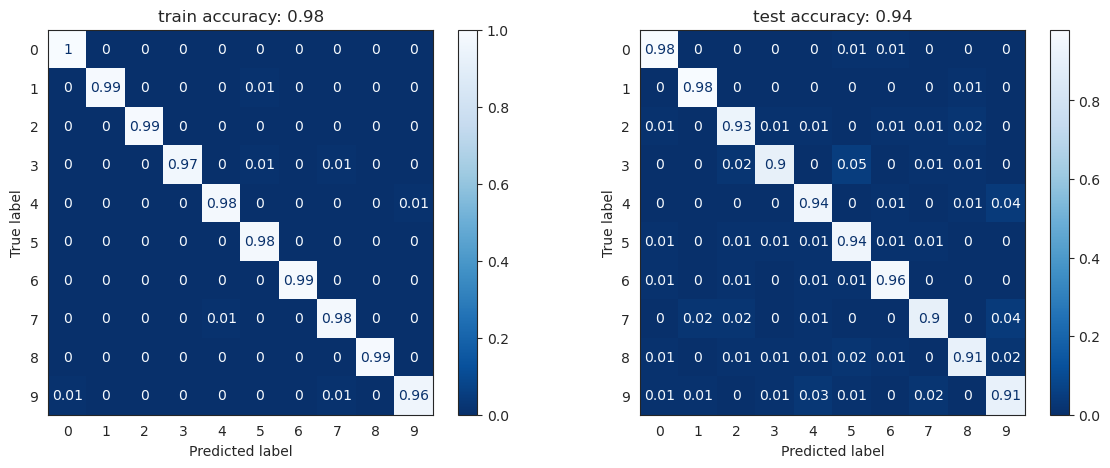

In [9]:
# Evaluate
X_ts, y_ts = np.array(data_ts, dtype=np.float32), np.array(targets_ts, dtype=np.float32)
_ = evaluate_model(model, X_tr, y_tr, X_ts, y_ts)

## PCA + SVM

Text(0.5, 1.0, 'Dimensionality Reduction by PCA')

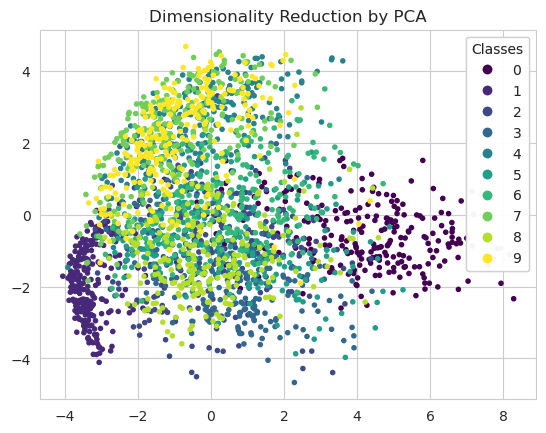

In [10]:
# Project data_tr to 2D
n_pcs = 2  
pca = PCA(n_components=n_pcs)
pca.fit(X_tr)
X_tr_pca = pca.transform(X_tr)

sns.set_style("whitegrid")
fig, ax = plt.subplots()
sh = ax.scatter(X_tr_pca[:, 0], X_tr_pca[:, 1], c=y_tr, marker=".", cmap="viridis")
legend1 = ax.legend(*sh.legend_elements(), title="Classes")
ax.add_artist(legend1)
ax.set_title("Dimensionality Reduction by PCA")

In [11]:
# Train 
X_tr_pca = pca.transform(X_tr)  # Project training data
model = SVC(kernel="rbf")
tick = time()
model.fit(X_tr_pca, y_tr)
print("Training Time for PCA+SVM:", time()-tick)

Training Time for PCA+SVM: 0.47266626358032227


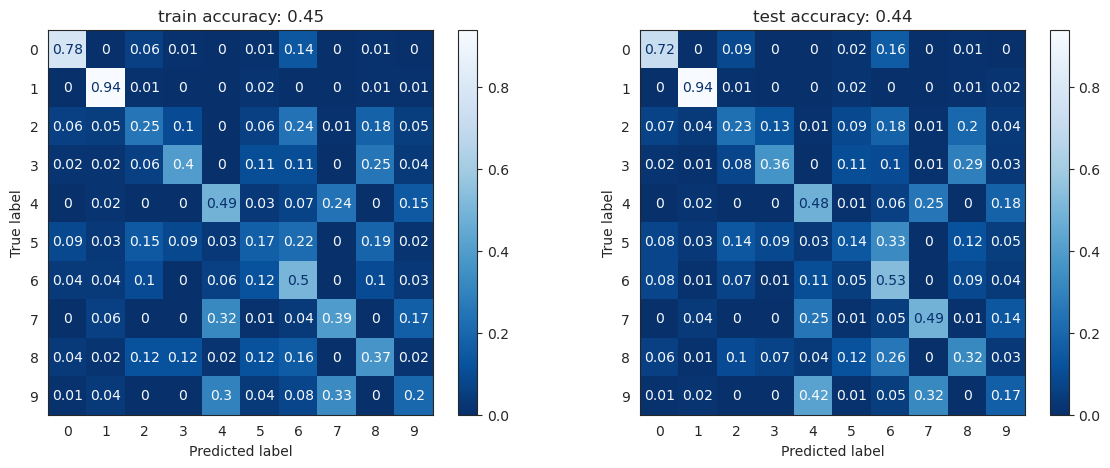

In [12]:
# Evaluate
X_ts_pca = pca.transform(X_ts)  # project test data
_ = evaluate_model(model, X_tr_pca, y_tr, X_ts_pca, y_ts)

We observe a very low performance accross all classes when we only use the first two PCs for projection.

In [13]:
# Increase the no. components
n_pcs = 9  
pca = PCA(n_components=n_pcs)
pca.fit(X_tr)

PCA(n_components=9)

In [14]:
# Train 
X_tr_pca = pca.transform(X_tr)  # Project training data
model = SVC(kernel="rbf")
tick = time()
model.fit(X_tr_pca, y_tr)
print("Training Time for PCA+SVM:", time()-tick)

Training Time for PCA+SVM: 0.20934176445007324


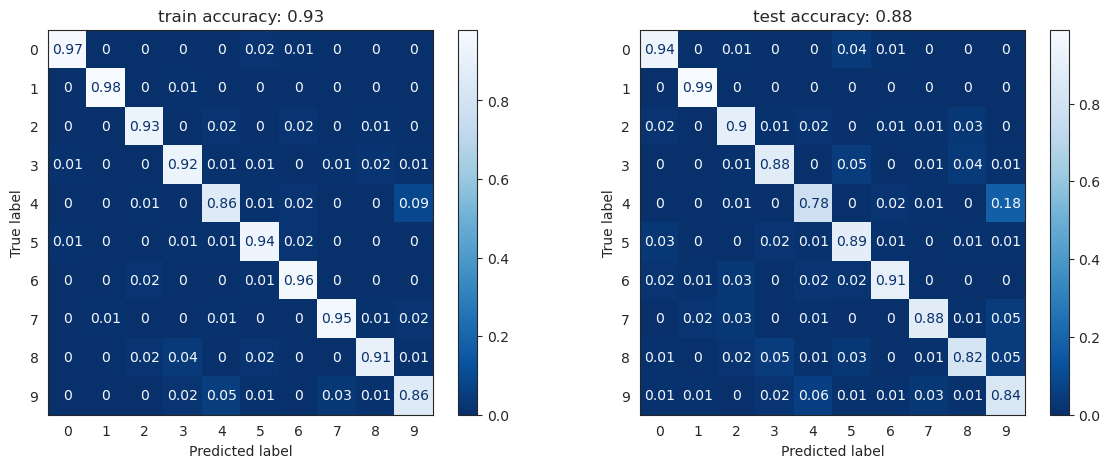

In [15]:
# Evaluate
X_ts_pca = pca.transform(X_ts)  # project test data
_ = evaluate_model(model, X_tr_pca, y_tr, X_ts_pca, y_ts)

It is observed that the both training and test accuracies increase by adding more number of PCs while dimensionality reduction. 

In [16]:
# Proportion of variance
pve = pca.explained_variance_ratio_
print("Proportion of Variance explained by each component:\n", pve)
print("Cumulative sum: ", pve.cumsum())

Proportion of Variance explained by each component:
 [0.09936659 0.07161687 0.06552844 0.05465055 0.04997871 0.04473659
 0.03348432 0.02983225 0.02863072]
Cumulative sum:  [0.09936659 0.17098346 0.23651192 0.29116246 0.34114116 0.38587776
 0.41936207 0.4491943  0.47782505]


It is observed that the first 9 PCs of the training data capture up to 47% of its variance. 

## LDA + SVM

Text(0.5, 1.0, 'Dimensionality Reduction by LDA')

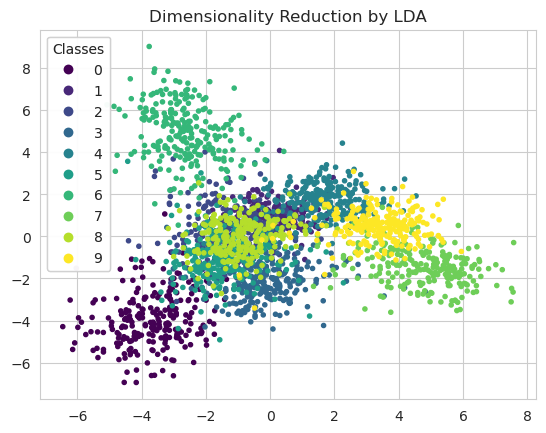

In [17]:
# Project data_tr to 2D
n_lda = 2  
lda = LinearDiscriminantAnalysis(n_components=n_lda)
lda.fit(X_tr, y_tr)
X_tr_lda = lda.transform(X_tr)

sns.set_style("whitegrid")
fig, ax = plt.subplots()
sh = ax.scatter(X_tr_lda[:, 0], X_tr_lda[:, 1], c=y_tr, marker=".", cmap="viridis")
legend1 = ax.legend(*sh.legend_elements(), title="Classes")
ax.add_artist(legend1)
ax.set_title("Dimensionality Reduction by LDA")

In [22]:
# Train
X_tr_lda = lda.transform(X_tr)  # project training data
model = SVC(kernel="rbf")
tick = time()
model.fit(X_tr_lda, y_tr)
print("Training time for LDA+SVM:", time()-tick)

Training time for LDA+SVM: 0.1795666217803955


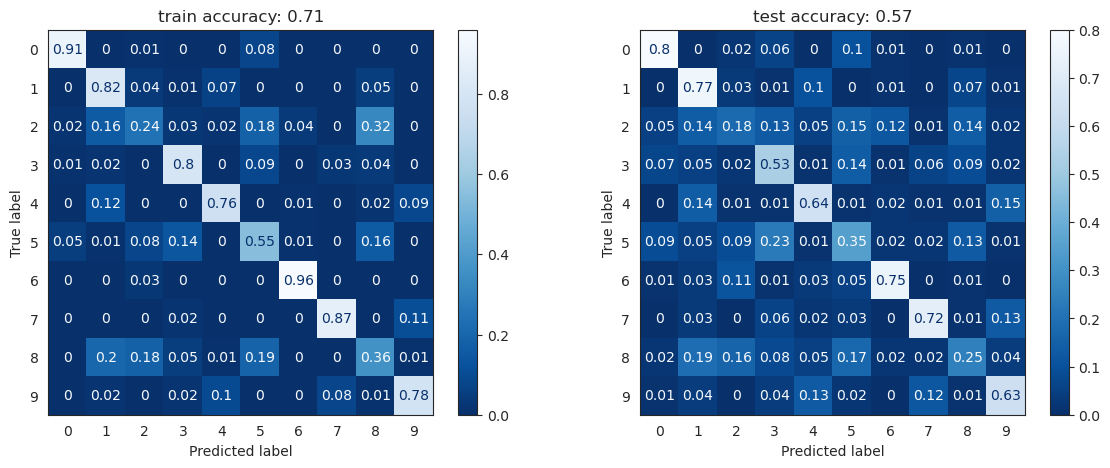

In [23]:
# Evaluate
X_ts_lda = lda.transform(X_ts)  
_ = evaluate_model(model, X_tr_lda, y_tr, X_ts_lda, y_ts)

Similar to PCA, it is observed that taking only two components for LDA analysis results in poor performance. We will increase the dimensionality to assess the performance.  

In [24]:
# Increase no. components
n_lda = 9  
lda = LinearDiscriminantAnalysis(n_components=n_lda)
lda.fit(X_tr, y_tr)
X_tr_lda = lda.transform(X_tr)

# Train
X_tr_lda = lda.transform(X_tr)  # project training data
model = SVC(kernel="rbf")
tick = time()
model.fit(X_tr_lda, y_tr)
print("Training time for LDA+SVM:", time()-tick)

Training time for LDA+SVM: 0.07197213172912598


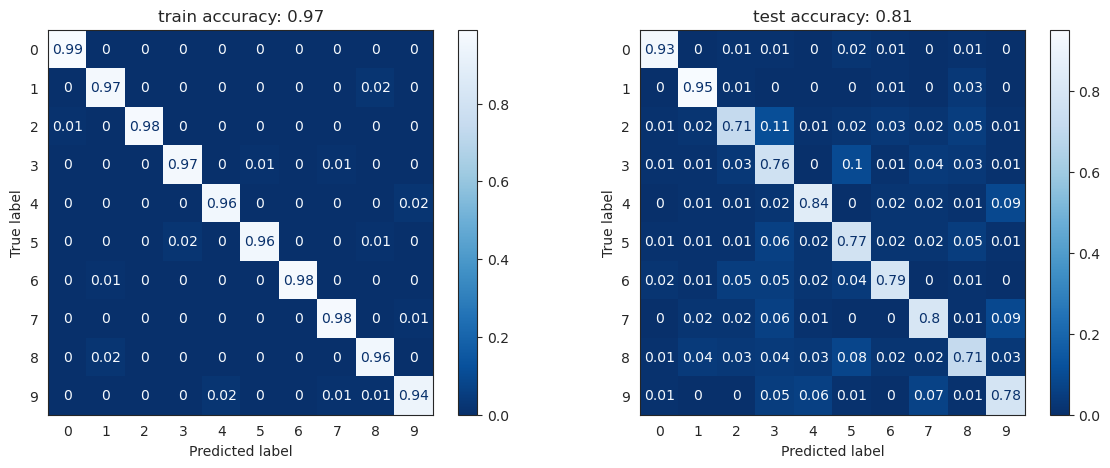

In [25]:
# Evaluate
X_ts_lda = lda.transform(X_ts)  
_ = evaluate_model(model, X_tr_lda, y_tr, X_ts_lda, y_ts)

It is observed that including only 9 components increases the test accuracy significantly. 